In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Load dataset

df = pd.read_csv('/content/drive/MyDrive/fer2013.csv')

In [3]:
print(df.emotion.value_counts())

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64


In [4]:
# Filter out unwanted emotions
#emotions= {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
df = df[df['emotion'].isin([3, 4, 5])]



In [5]:
#Renaming Happy to Happy_Moments, Sad to Sad_Moments and Surprise to Goal_Moments
label_to_text = {3:'Happy_Moments', 4: 'Loss_Moments', 5:'Goal_Moments'}



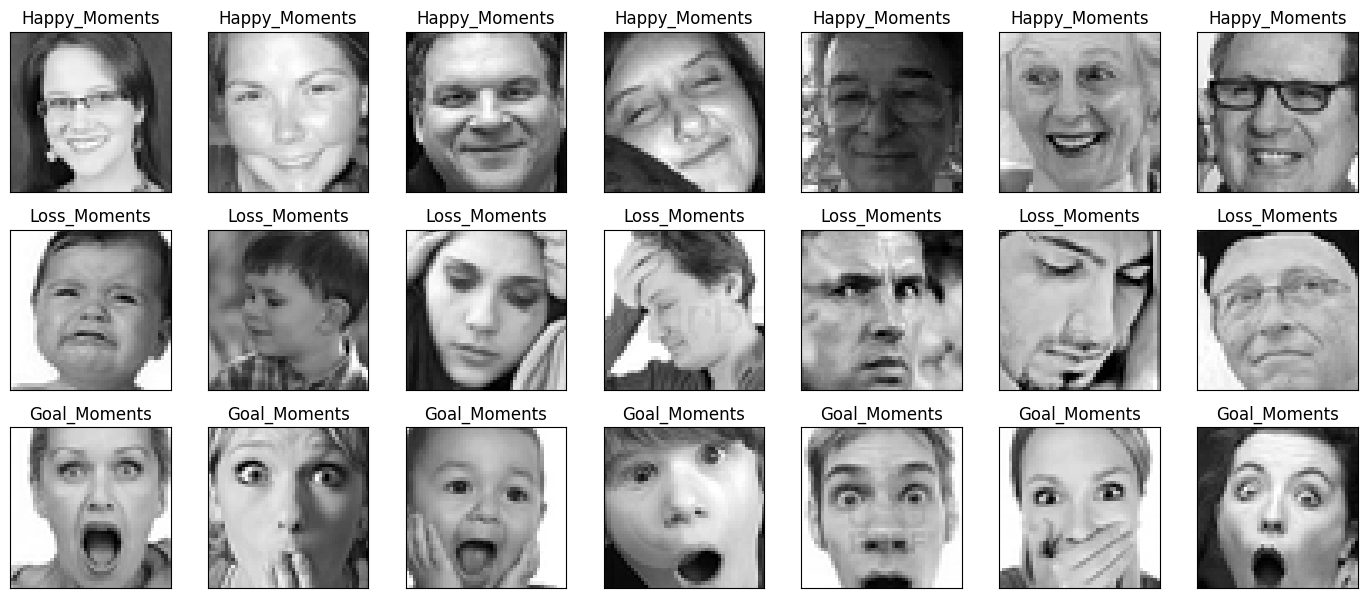

In [6]:
# Visualize emotions
fig = plt.figure(1, (14, 14))
k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion == label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        plt.tight_layout()



In [7]:
# Preprocessing
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)


In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)

In [9]:
# Normalization
X_train = X_train / 255.
X_test = X_test / 255.


In [10]:
# Data Augmentation
train_datagen = ImageDataGenerator(horizontal_flip=True)
train_generator = train_datagen.flow(X_train, y_train, batch_size=64)
validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow(X_test, y_test, batch_size=64)

In [11]:
# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

# Print model summary
model.summary()

# Define callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Calculate steps_per_epoch
steps_per_epoch = math.ceil(len(X_train) / 64)

# Train the model
history = model.fit(
    x=train_generator,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30
)

# Save model architecture and weights
model.save('emotion_recognition_model.keras')



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │              

 Total params: 692,739 (2.64 MB)

 Trainable params: 691,907 (2.64 MB)

 Non-trainable params: 832 (3.25 KB)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


269/269 ━━━━━━━━━━━━━━━━━━━━ 29s 54ms/step - accuracy: 0.4793 - loss: 1.2386 - val_accuracy: 0.4714 - val_loss: 1.5657
Epoch 2/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4714 - val_loss: 1.5682
Epoch 3/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


269/269 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.6346 - loss: 0.8391 - val_accuracy: 0.6329 - val_loss: 0.7940
Epoch 4/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6329 - val_loss: 0.7936
Epoch 5/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6872 - loss: 0.7106 - val_accuracy: 0.7305 - val_loss: 0.6297
Epoch 6/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7305 - val_loss: 0.6304
Epoch 7/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7364 - loss: 0.6183 - val_accuracy: 0.7745 - val_loss: 0.5425
Epoch 8/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7745 - val_loss: 0.5398
Epoch 9/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7581 - loss: 0.5723 - val_accuracy: 0.7399 - val_loss: 0.6056
Epoch 10/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - accuracy: 0.0000e+00 - loss: 